In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from nbc_analysis.utils.toml_utils import get_config
from nbc_analysis.utils.debug_utils import runit
from nbc_analysis.utils.file_utils import read_parquet

import pandas as pd
import numpy as np

from toolz import *
from itertools import starmap

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
config = get_config('test')
config

{'calendar': {'start_day_key': 20170101,
  'end_day_key': 20210101,
  'calendar_d': PosixPath('/Users/wmcabee/DATA/NBC/calendar')},
 'database': {'db_f': PosixPath('/Users/wmcabee/DATA/NBC/test_db.sqlite'),
  'connect_str': 'sqlite:////%s'},
 'demographics': {'demographics_d': PosixPath('/Users/wmcabee/DATA/NBC/demographics'),
  'zip2income_input_f': PosixPath('/Users/wmcabee/_NBC/datasets/ACS_17_5YR_S2503_with_ann.csv'),
  'subnet2zip_input_f': PosixPath('/Users/wmcabee/_NBC/datasets/GeoLite2-City-CSV_20191001.zip')},
 'normalize': {'test_input_d': PosixPath('/Users/wmcabee/DATA/NBC/work/query'),
  'normalize_d': PosixPath('/Users/wmcabee/DATA/NBC/normalize')}}

In [6]:
normalize_d = get_in(['normalize','normalize_d'], config)
demographics_d = get_in(['demographics','demographics_d'], config)

fact = read_parquet('f_video_end.parquet', normalize_d)
network_dim = read_parquet('dim_network', demographics_d, columns=['network_key', 'time_zone'])

2019-10-24 13:14:14,372|INFO|nbc_analysis.utils.file_utils|start read file,/Users/wmcabee/DATA/NBC/normalize/f_video_end.parquet
2019-10-24 13:14:14,495|INFO|nbc_analysis.utils.file_utils|end read file,/Users/wmcabee/DATA/NBC/normalize/f_video_end.parquet,record_cnt=208613
2019-10-24 13:14:14,496|INFO|nbc_analysis.utils.file_utils|start read file,/Users/wmcabee/DATA/NBC/demographics/dim_network.parquet
2019-10-24 13:14:14,582|INFO|nbc_analysis.utils.file_utils|end read file,/Users/wmcabee/DATA/NBC/demographics/dim_network.parquet,record_cnt=1243177


In [49]:
list(demographics_d.glob('*'))

[PosixPath('/Users/wmcabee/DATA/NBC/demographics/network_dim.parquet')]

In [115]:
lkup = network_dim.set_index('network_key').time_zone
df = fact[['network_key','event_start_dt']].copy()#[:60000]
df['time_zone'] = df.network_key.map(lkup)

DATA =df
DATA.head()

,network_key,event_start_dt,time_zone
0,14111283841451506785,20190822T021900.447999Z,America/Chicago
1,8941847876039483264,20190818T235920.055000Z,America/Chicago
2,10091593832033848793,20190818T235846.785000Z,America/New_York
3,8941847876039483264,20190818T235840.855999Z,America/Chicago
4,13658938058864572755,20190818T235741.346999Z,America/New_York


In [119]:
%%time
#ds = df.event_start_dt.map(pd.to_datetime)
# ds.dt.tz_convert(tz)

data =DATA.copy()
def convert2tz(g, ds):
    print(g, len(ds))
    if g == 'Not Set':
        df = pd.Series(pd.NaT, index=ds.index).to_frame('event_start_local_dt')
        df['hour'] = np.NaN
        df['day_of_week'] = np.NaN
        df['hour_of_week'] = np.NaN
        return df
    ds = ds.map(lambda x: pd.to_datetime(x, utc=True))
    df = ds.dt.tz_convert(g).to_frame('event_start_local_dt')
    df['hour'] = df.event_start_local_dt.dt.hour
    df['day_of_week'] = df.event_start_local_dt.dt.dayofweek
    df['hour_of_week'] = (df.day_of_week * 24) + df.hour
    return df

reader = iter(data.groupby('time_zone').event_start_dt)
reader = starmap(convert2tz,reader)
reader = filter(lambda x: x is not None, reader)
dx = pd.concat(reader)
dx = dx.reindex(index=df.index)

America/Anchorage 256
America/Boise 842
America/Chicago 51504
America/Denver 9099
America/Detroit 5682
America/Indiana/Indianapolis 3037
America/Indiana/Marengo 4
America/Indiana/Petersburg 8
America/Indiana/Tell_City 56
America/Indiana/Vincennes 17
America/Indiana/Winamac 1
America/Juneau 12
America/Kentucky/Louisville 886
America/Los_Angeles 31045
America/Menominee 39
America/New_York 86457
America/Nome 10
America/North_Dakota/Beulah 13
America/North_Dakota/New_Salem 49
America/Phoenix 3968
America/Sitka 5
Not Set 14792
Pacific/Honolulu 831
CPU times: user 26 s, sys: 70.8 ms, total: 26.1 s
Wall time: 26 s


93.0     2702
45.0     2598
69.0     2498
46.0     2476
94.0     2412
         ... 
76.0      293
77.0      290
4.0       280
149.0     277
5.0       252
Name: hour_of_week, Length: 168, dtype: int64

In [140]:
dy = dx.hour_of_week.dropna().astype(np.int).value_counts(sort=False).sort_index().fillna(-1)

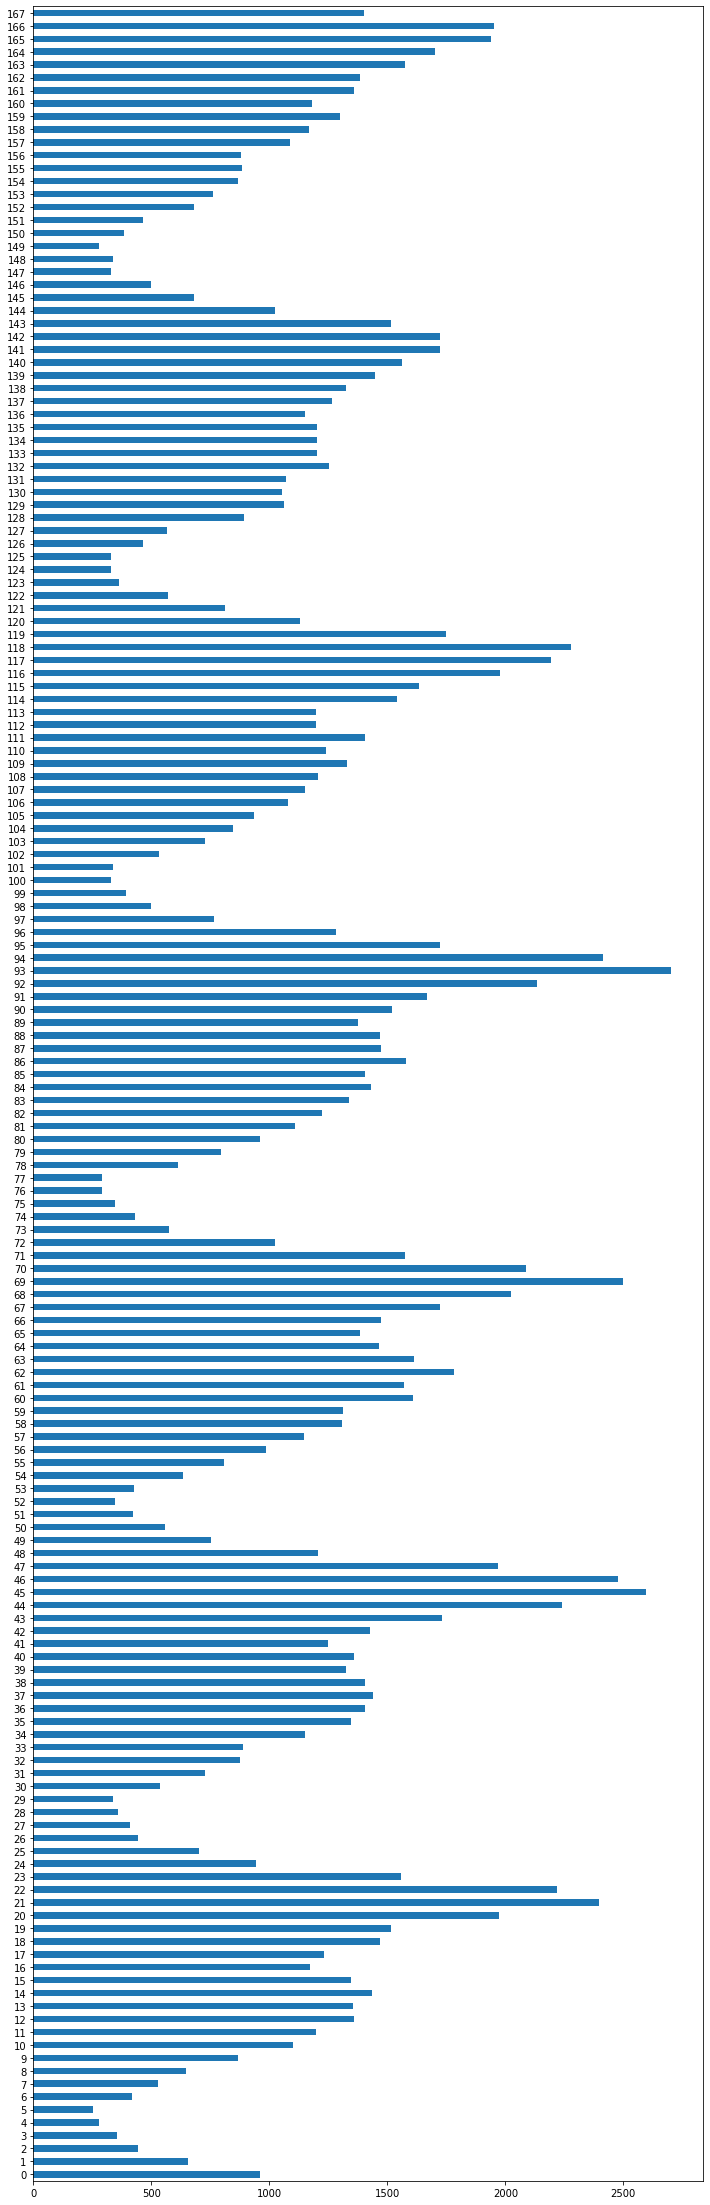

In [141]:
fig = plt.figure(figsize=(12,40))
dy.plot(kind='barh')

In [23]:
fact

,day_utc_key,video_key,platform_key,profile_key,end_type_key,event_type_key,network_key,mpid,event_start_dt,video_duration_watched,resume_time,_file,_file_idx,_batch_id,_viewer_partition,_last_upd_dt
0,20190822,15249924849943320638,13512958757101649953,5612241246451325071,1543738608339601720,10286261140990397066,14111283841451506785,6971930039803442160,20190822T021900.447999Z,0.000000,NaN,NBC_App_20190808022157356847_93336.txt,951,ve_20190808_0001,0,1566440340448
1,20190818,9379374450212694540,13512958757101649953,5612241246451325071,1543738608339601720,10286261140990397066,8941847876039483264,-1699799465028187080,20190818T235920.055000Z,0.200000,NaN,NBC_App_20190818235940675975_41044.txt,8603,ve_20190818_0008,0,1566172760055
2,20190818,5335255399160415779,13512958757101649953,5612241246451325071,14134703689083528527,10286261140990397066,10091593832033848793,4772427038475211860,20190818T235846.785000Z,41.050000,2347.0,NBC_App_20190818235947282705_86587.txt,8604,ve_20190818_0008,0,1566172726785
3,20190818,6723486805398926064,13512958757101649953,5612241246451325071,1543738608339601720,10286261140990397066,8941847876039483264,-1699799465028187080,20190818T235840.855999Z,5.983333,NaN,NBC_App_20190818235947282705_86587.txt,8604,ve_20190818_0008,0,1566172720856
4,20190818,3433543031427619821,13512958757101649953,5612241246451325071,14134703689083528527,10286261140990397066,13658938058864572755,-4762455741229315080,20190818T235741.346999Z,80.016667,4536.0,NBC_App_20190818235811154757_37909.txt,8590,ve_20190818_0008,0,1566172661347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208608,20180813,3687281119820901955,2356253770914521728,5612241246451325071,1543738608339601720,10286261140990397066,11010168467929446606,4027393590668048640,20180813T051700.099999Z,6.000000,NaN,NBCUniversal_20190818141556388242_01410.txt,5114,ve_20190818_0004,0,1534137420100
208609,20180801,14008209082211965090,2356253770914521728,5894746954545069528,7968799331887820946,10286261140990397066,18439815157026059949,-4592284287176992620,20180801T235931.740999Z,84.000000,NaN,NBC_20190806174214418462_85731.txt,7444,ve_20190806_0006,0,1533167971741
208610,20180723,10257777878610075209,13757614714000885976,5612241246451325071,15583778122025838304,10286261140990397066,355616872037361773,-4813396560726335460,20180723T004438.059999Z,0.000000,NaN,NBC_20190807032124656740_55497.txt,1395,ve_20190807_0002,0,1532306678060
208611,20180715,11819162619886862771,2356253770914521728,5612241246451325071,7968799331887820946,10286261140990397066,12346442020451234714,628802053897368660,20180715T005829.346999Z,37.000000,NaN,NBC_20190806113209660673_02811.txt,4817,ve_20190806_0004,0,1531616309347
